In [1]:
import jax 
import cfp
import scanpy as sc
import anndata as ad
import numpy as np
import cfp.preprocessing as cfpp
import pandas as pd

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
out_dir = "/lustre/groups/ml01/workspace/ot_perturbation/analysis/sciplex"

In [3]:
split = 10
model_name = "clean-voice-1"

adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_{split}.h5ad"
adata_train = sc.read_h5ad(adata_train_path)
adata_test = sc.read_h5ad(adata_test_path)
adata_ood = sc.read_h5ad(adata_ood_path)
    



In [4]:
covariate_data_ood = adata_ood[~adata_ood.obs["condition"].str.contains("Vehicle")].obs.drop_duplicates(subset=["cell_line", "drug"])
covariate_data_test = adata_test[~adata_test.obs["condition"].str.contains("Vehicle")].obs.drop_duplicates(subset=["cell_line", "drug"])


In [5]:
covariate_data = covariate_data_ood[(covariate_data_ood["cell_line"]=="MCF7") & (covariate_data_ood["drug"]=="Dacinostat_(LAQ824)")]

In [6]:
covariate_data

,cell_type,dose,dose_character,dose_pattern,g1s_score,g2m_score,pathway,pathway_level_1,pathway_level_2,product_dose,...,pubchem_name,pubchem_ID,smiles,control,ood_1,ood_2,ood_3,ood_4,ood_5,split
index,,,,,,,,,,,,,,,,,,,,,
A01_E09_RT_BC_129_Lig_BC_265-1-0,MCF7,10.0,10,4,2.09247,0.884173,Epigenetics,Epigenetic regulation,Histone deacetylation,Dacinostat (LAQ824)_10,...,NaN,NaN,C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=...,False,not ood,not ood,MCF7_Dacinostat_(LAQ824)_10.0,not ood,MCF7_Dacinostat_(LAQ824)_10.0,ood


In [7]:
def duplicate_and_interpolate(df, column, start, end, steps):
    result = pd.DataFrame()
    
    for _, row in df.iterrows():
        new_rows = pd.DataFrame([row] * steps)  # Duplicate the row
        new_rows[column] = np.linspace(start, end, steps)  # Interpolate 'logdose'
        result = pd.concat([result, new_rows], ignore_index=True)
    
    return result

covariate_data_interpolated = duplicate_and_interpolate(covariate_data, 'logdose', 1.0, 4.0, 10)

In [8]:
covariate_data_interpolated["logdose"].value_counts()

logdose
1.000000    1
1.333333    1
1.666667    1
2.000000    1
2.333333    1
2.666667    1
3.000000    1
3.333333    1
3.666667    1
4.000000    1
Name: count, dtype: int64

In [9]:
adata_ood_ctrl = adata_ood[(adata_ood.obs["condition"].str.contains("Vehicle")) & (adata_ood.obs["cell_line"]=="MCF7")]
adata_ood_ctrl.obs["control"].value_counts()

control
True    500
Name: count, dtype: int64

In [10]:
adata_ood_ctrl.obs["condition"].value_counts()

condition
MCF7_Vehicle_0.0    500
Name: count, dtype: int64

In [11]:
cf = cfp.model.CellFlow.load(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/sciplex_final/{model_name}_CellFlow.pkl")



In [12]:
covariate_data_interpolated.loc[:, "condition"] = covariate_data_interpolated.apply(lambda x: "_".join([x.cell_type, x.drug, str(x.logdose)]), axis=1)

In [13]:
preds_ood = cf.predict(adata=adata_ood_ctrl, sample_rep="X_pca", condition_id_key="condition", covariate_data=covariate_data_interpolated)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:551: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[self._control_key] = adata.obs[self._control_key].astype(
/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 10/10 [00:00<00:00, 52.49it/s]


In [14]:
all_data = []
conditions = []

for condition, array in preds_ood.items():
    all_data.append(array)
    conditions.extend([condition] * array.shape[0])

# Stack all data vertically to create a single array
all_data_array = np.vstack(all_data)

# Create a DataFrame for the .obs attribute
obs_data = pd.DataFrame({
    'condition': conditions
})

# Create the Anndata object
adata_ood_result = ad.AnnData(X=np.empty((len(all_data_array),2001)), obs=obs_data)
adata_ood_result.obsm["X_pca_pred"] = all_data_array


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
cfpp.reconstruct_pca(query_adata=adata_ood_result, use_rep="X_pca_pred", ref_adata=adata_train, layers_key_added="X_recon_pred")


In [16]:
adata_ood_result.X = adata_ood_result.layers["X_recon_pred"]

In [17]:
sc.pp.pca(adata_ood_result)
sc.pp.neighbors(adata_ood_result)
sc.tl.umap(adata_ood_result)

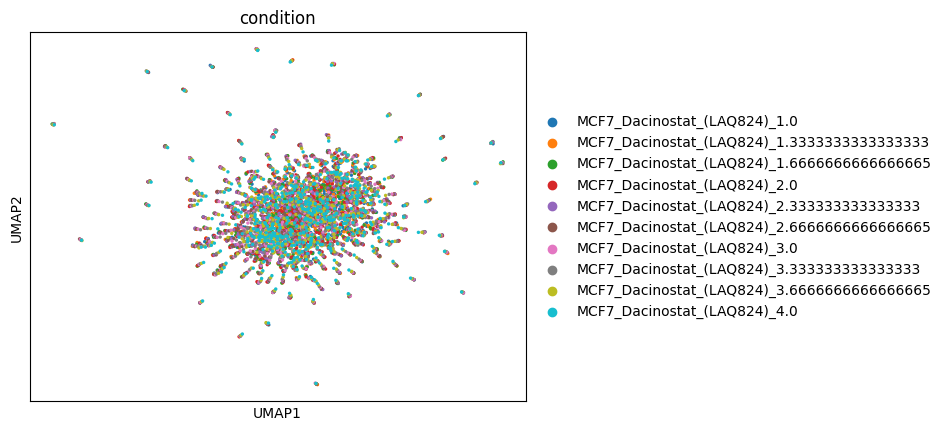

In [18]:
sc.pl.umap(adata_ood_result, color="condition")

In [19]:
adata_true_perturbed = adata_ood[(adata_ood.obs["drug"]=="Dacinostat_(LAQ824)") & (adata_ood.obs["cell_type"]=="MCF7")]
adata_true = ad.concat((adata_ood_ctrl, adata_true_perturbed))

In [20]:
adata_ood_result.var_names = adata_true.var_names

In [21]:
adata_ood_result.obs["condition"].unique()

['MCF7_Dacinostat_(LAQ824)_1.0', 'MCF7_Dacinostat_(LAQ824)_1.3333333333333333', 'MCF7_Dacinostat_(LAQ824)_1.6666666666666665', 'MCF7_Dacinostat_(LAQ824)_2.0', 'MCF7_Dacinostat_(LAQ824)_2.333333333333333', 'MCF7_Dacinostat_(LAQ824)_2.6666666666666665', 'MCF7_Dacinostat_(LAQ824)_3.0', 'MCF7_Dacinostat_(LAQ824)_3.333333333333333', 'MCF7_Dacinostat_(LAQ824)_3.6666666666666665', 'MCF7_Dacinostat_(LAQ824)_4.0']
Categories (10, object): ['MCF7_Dacinostat_(LAQ824)_1.0', 'MCF7_Dacinostat_(LAQ824)_1.3333333333333333', 'MCF7_Dacinostat_(LAQ824)_1.6666666666666665', 'MCF7_Dacinostat_(LAQ824)_2.0', ..., 'MCF7_Dacinostat_(LAQ824)_3.0', 'MCF7_Dacinostat_(LAQ824)_3.333333333333333', 'MCF7_Dacinostat_(LAQ824)_3.6666666666666665', 'MCF7_Dacinostat_(LAQ824)_4.0']

In [22]:
sc.tl.rank_genes_groups(adata_true, groupby="dose", reference=0.0)

In [23]:
df_logfoldchange = sc.get.rank_genes_groups_df(adata_true, group="10000.0")

In [24]:
df_downregulated = df_logfoldchange.sort_values("logfoldchanges", ascending=True)
df_upregulated = df_logfoldchange.sort_values("logfoldchanges", ascending=False)
df_downregulated = df_downregulated[df_downregulated["logfoldchanges"]<0]
df_upregulated = df_upregulated[df_upregulated["logfoldchanges"]>0]

In [25]:
df_upregulated.head()

,names,scores,logfoldchanges,pvals,pvals_adj
15,LINC02204,15.345857,28.965729,9.037839e-43,7.535299e-41
16,CEACAM20,15.198580,28.506819,3.927578e-42,3.143634e-40
21,LINC02158,13.308126,28.275150,3.957531e-34,2.262577e-32
30,IRGM,11.170289,28.248959,1.229955e-25,4.922279e-24
33,AC138819.1,10.637078,27.645252,1.224776e-23,4.713032e-22


In [26]:
df_downregulated.head()

,names,scores,logfoldchanges,pvals,pvals_adj
1953,AC079160.1,-4.705803,-24.427870,0.000003,0.000042
1893,NDUFA4L2,-1.350734,-22.285740,0.177393,0.870007
1923,ARHGAP15,-2.021492,-21.890471,0.043762,0.299890
1914,AC105999.2,-1.760731,-21.685043,0.078896,0.479390
1869,AC006369.1,-1.000000,-21.525599,0.317795,1.000000


In [27]:
adata_true.obs["mode"] = "True"
adata_ood_result.obs["mode"] = "pred"

In [28]:
adata_joint = ad.concat((adata_true, adata_ood_result))

In [29]:
sc.pp.pca(adata_joint, n_comps=5)
sc.pp.neighbors(adata_joint)
sc.tl.umap(adata_joint)

In [30]:
adata_joint.obs["dose"] = adata_joint.obs.apply(lambda x: x["condition"].split("_")[-1], axis=1)

In [31]:
adata_joint.obs["dose"] =adata_joint.obs["dose"].astype("float") 

In [32]:
adata_joint.obs["logdose"] = adata_joint.obs.apply(lambda x: np.log10(x["dose"]) if (x["dose"] in [10, 100, 1000, 10000]) else x["dose"], axis=1)

In [33]:
adata_joint.obs["logdose"].value_counts()

logdose
1.000000    954
4.000000    935
3.000000    858
2.000000    820
0.000000    500
1.333333    500
1.666667    500
2.333333    500
2.666667    500
3.333333    500
3.666667    500
Name: count, dtype: int64

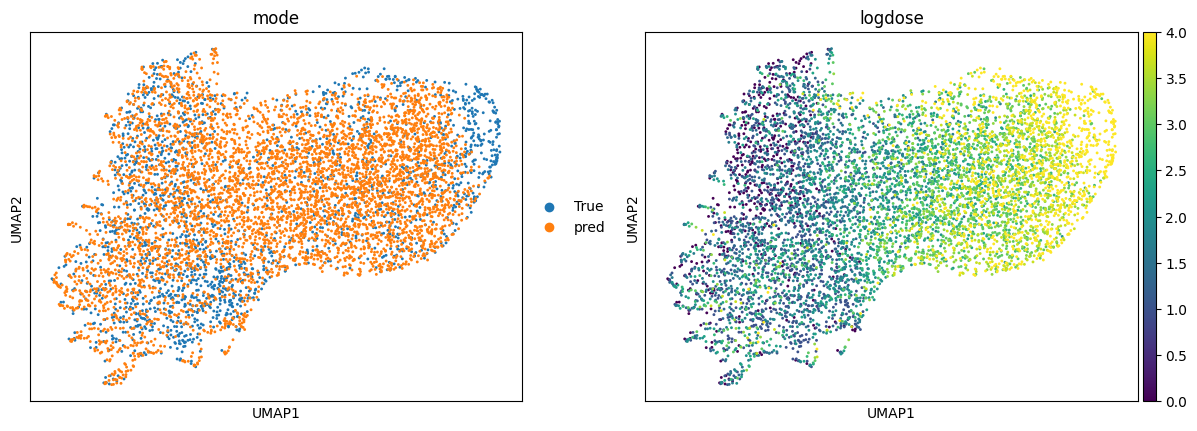

In [34]:
sc.pl.umap(adata_joint, color=["mode", "logdose"])

In [35]:
import os
adata_joint.write_h5ad(os.path.join(out_dir, "pseudodosages_dacinostat.h5ad"))

In [36]:
upregulated_genes =  list(df_upregulated.sort_values("pvals_adj")[:10].names.values)
downregulated_genes =  list(df_downregulated.sort_values("pvals_adj")[:10].names.values)
df_upregulation = sc.get.obs_df(adata_joint, keys=upregulated_genes+['logdose'])
df_upregulation["mode"] =adata_joint.obs["mode"]
df_downregulation = sc.get.obs_df(adata_joint, keys=downregulated_genes+['logdose'])
df_downregulation["mode"] =adata_joint.obs["mode"]

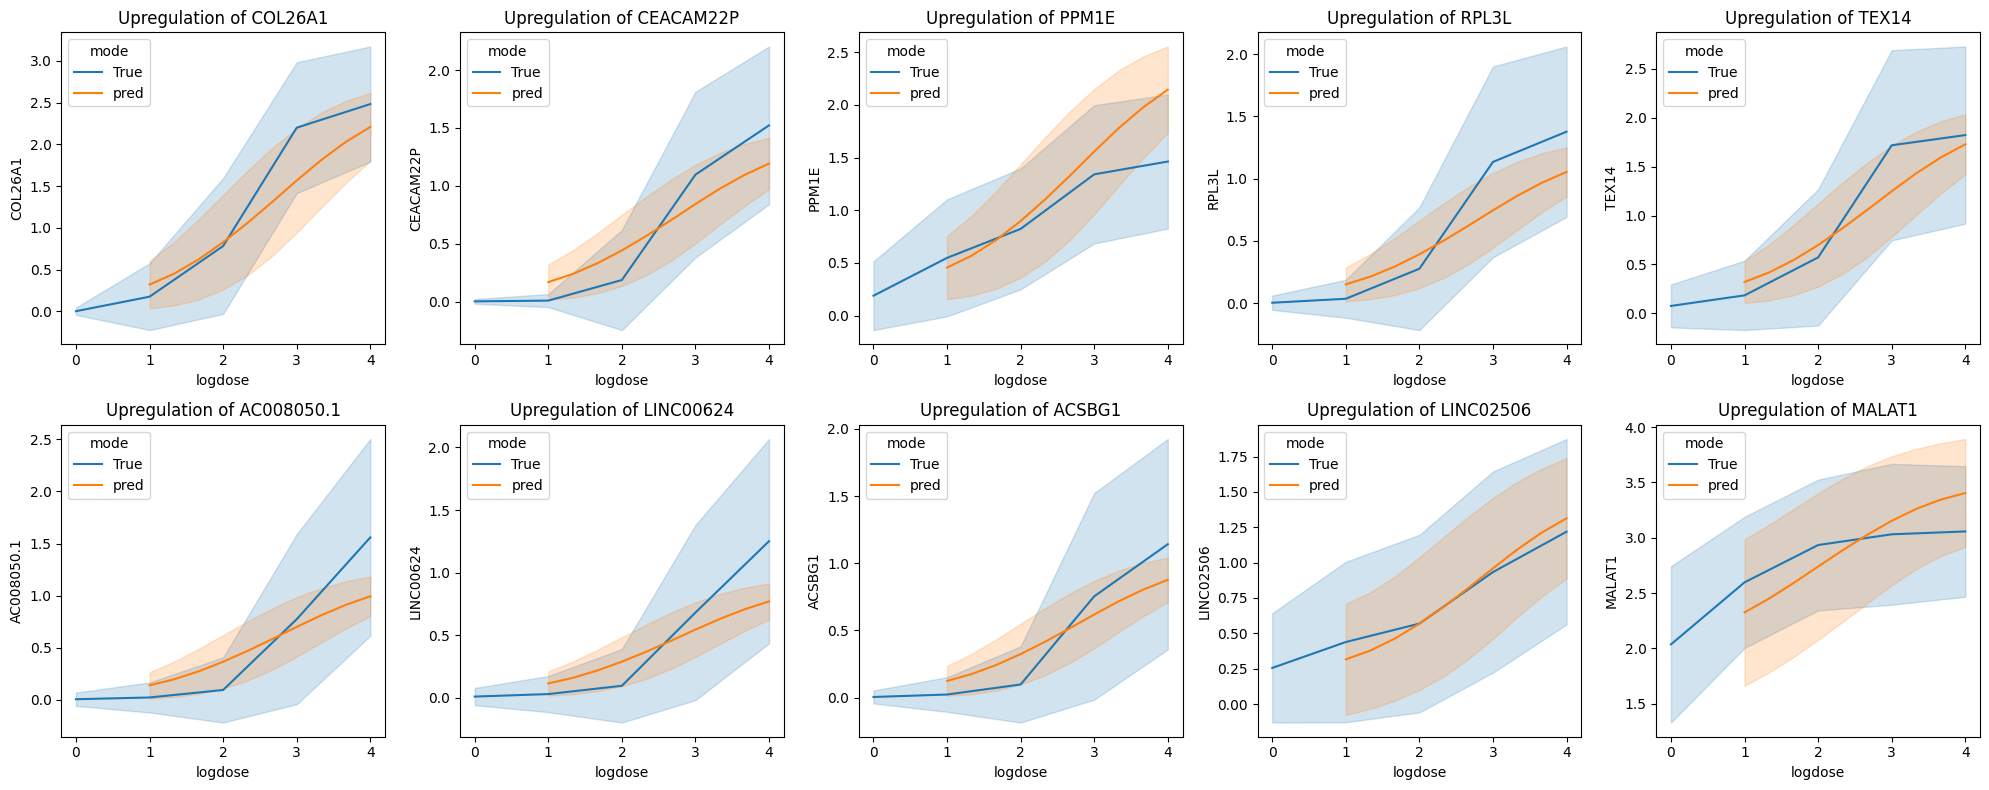

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define number of rows and columns for 5 plots per row
num_genes = len(upregulated_genes)
cols = 5
rows = math.ceil(num_genes / cols)  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

# Flatten axes array in case it's a multi-dimensional array
axes = axes.flatten()

# Create a lineplot for each gene
for i, gene in enumerate(upregulated_genes):
    sns.lineplot(data=df_upregulation, x='logdose', y=gene, errorbar='sd', hue="mode", ax=axes[i])
    axes[i].set_title(f'Upregulation of {gene}')

# Remove any unused subplots if the number of genes isn't a multiple of 5
for i in range(num_genes, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


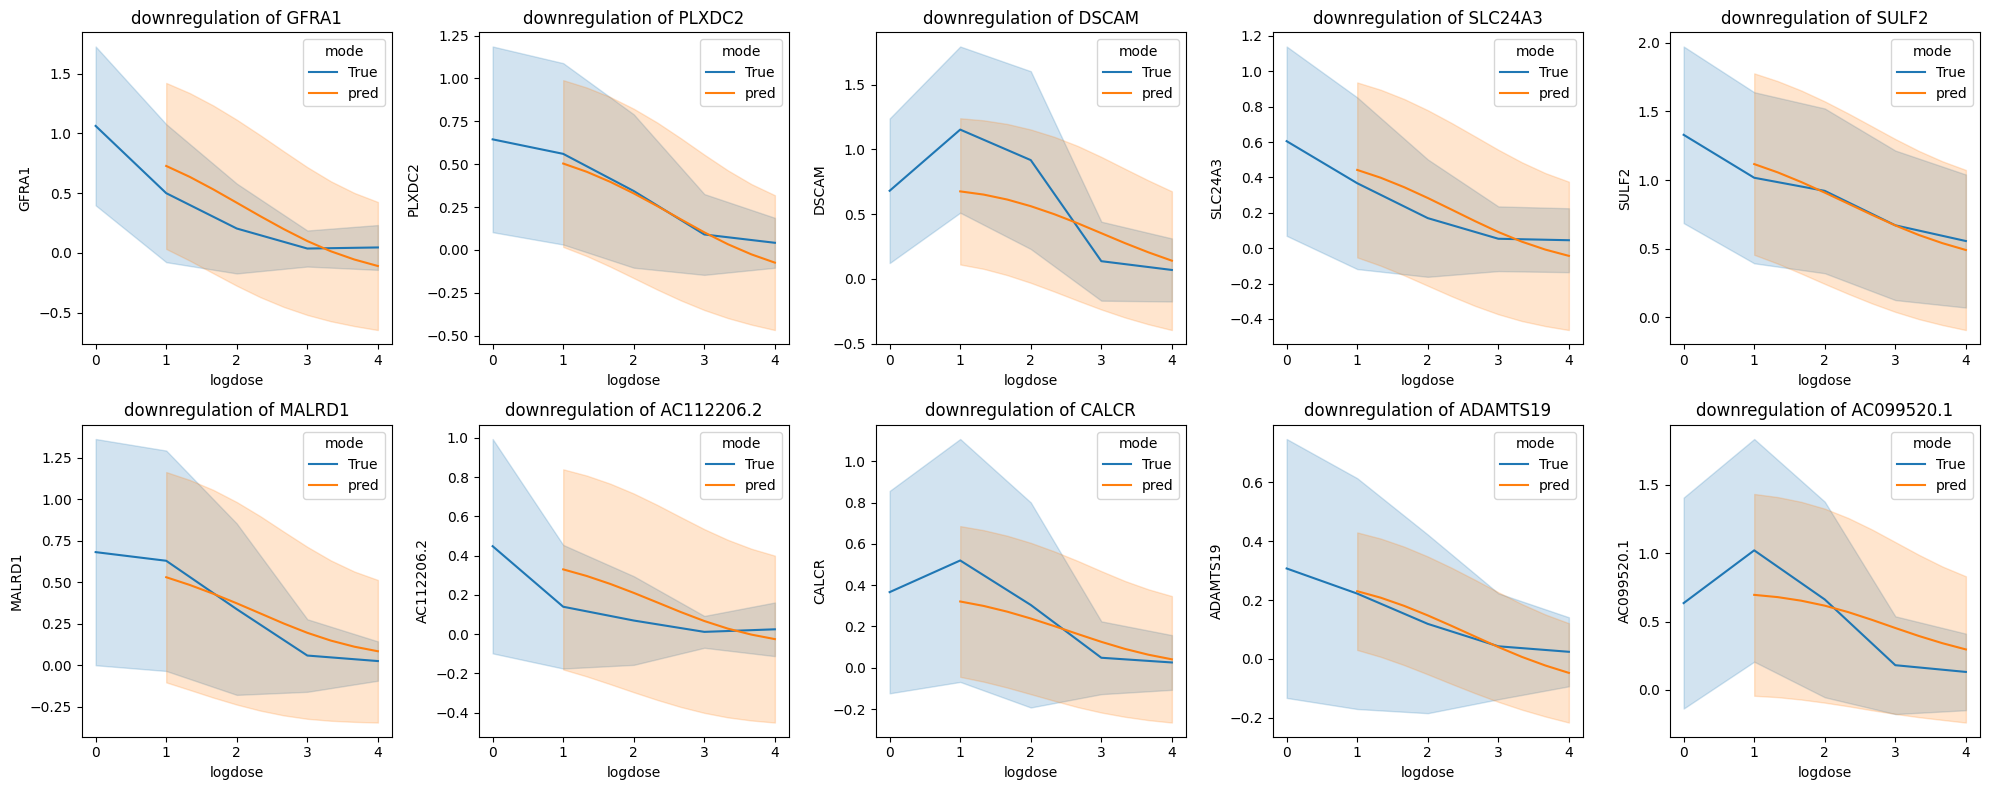

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define number of rows and columns for 5 plots per row
num_genes = len(downregulated_genes)
cols = 5
rows = math.ceil(num_genes / cols)  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

# Flatten axes array in case it's a multi-dimensional array
axes = axes.flatten()

# Create a lineplot for each gene
for i, gene in enumerate(downregulated_genes):
    sns.lineplot(data=df_downregulation, x='logdose', y=gene, errorbar='sd', hue="mode", ax=axes[i])
    axes[i].set_title(f'downregulation of {gene}')

# Remove any unused subplots if the number of genes isn't a multiple of 5
for i in range(num_genes, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


/tmp/ipykernel_1056120/1317999174.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_data = df_downregulation[df_downregulation['mode'] == 'pred'].groupby('logdose').apply(lambda x: x.sample(4, random_state=42)).reset_index(drop=True)
/tmp/ipykernel_1056120/1317999174.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  non_pred_data = df_downregulation[df_downregulation['mode'] != 'pred'].groupby('l

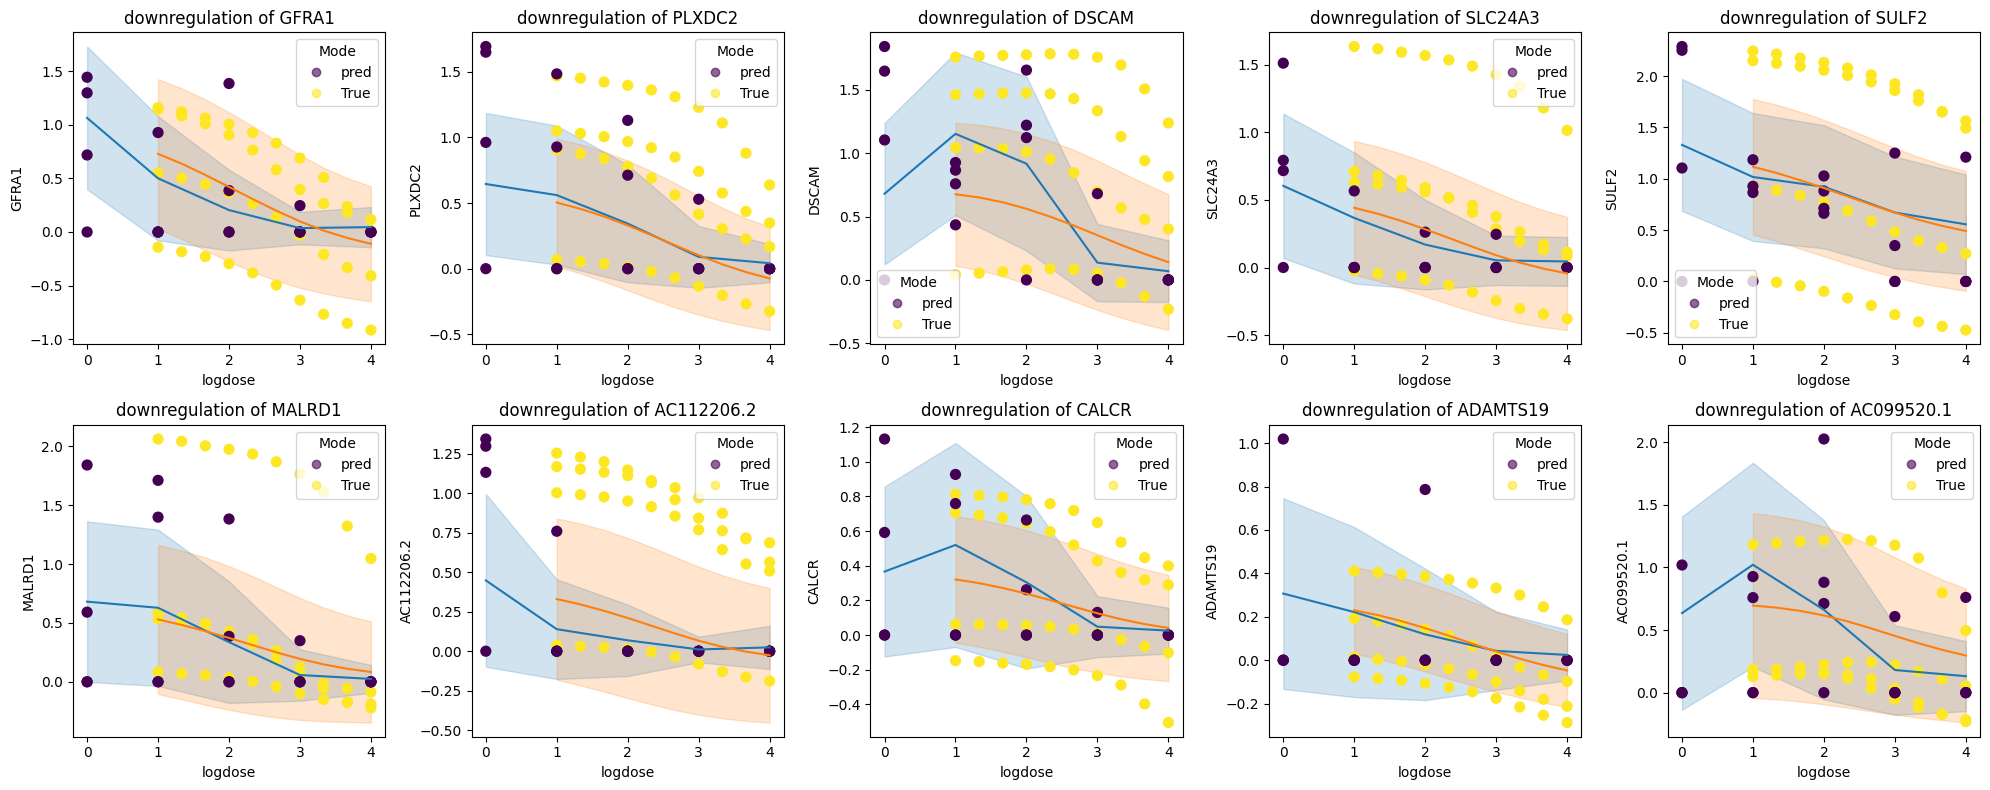

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define number of rows and columns for 5 plots per row
num_genes = len(downregulated_genes)
cols = 5
rows = math.ceil(num_genes / cols)  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

# Flatten axes array in case it's a multi-dimensional array
axes = axes.flatten()

# Create a lineplot for each gene
for i, gene in enumerate(downregulated_genes):
    # Create line plot
    sns.lineplot(data=df_downregulation, x='logdose', y=gene, errorbar='sd', hue="mode", ax=axes[i])

    # Filter and select exactly 4 data points per logdose for "pred"
    pred_data = df_downregulation[df_downregulation['mode'] == 'pred'].groupby('logdose').apply(lambda x: x.sample(4, random_state=42)).reset_index(drop=True)

    # Select up to 4 data points for other modes, if available
    non_pred_data = df_downregulation[df_downregulation['mode'] != 'pred'].groupby('logdose').apply(lambda x: x.sample(4, random_state=42)).reset_index(drop=True)

    # Combine both selections
    selected_data = pd.concat([pred_data, non_pred_data])

    # Scatter plot to add specific points and color them by 'mode'
    scatter = axes[i].scatter(selected_data['logdose'], selected_data[gene], c=selected_data['mode'].astype('category').cat.codes, cmap='viridis', s=50, label='4 Data Points per logdose')

    # Create colorbar for 'mode'
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = selected_data['mode'].unique()
    axes[i].legend(handles, legend_labels, title="Mode")

    axes[i].set_title(f'downregulation of {gene}')

# Remove any unused subplots if the number of genes isn't a multiple of 5
for i in range(num_genes, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [40]:
df_upregulated.to_csv(os.path.join(out_dir, "upregulated_genes_Dacinostat.csv"))
df_downregulated.to_csv(os.path.join(out_dir, "downregulated_genes_Dacinostat.csv"))
df_upregulation.to_csv(os.path.join(out_dir, "upregulated_data_Dacinostat.csv"))
df_downregulation.to_csv(os.path.join(out_dir, "downregulated_data_Dacinostat.csv"))